In [1]:
%cd ../../ 

/media/Windows/Users/white/Documents/UTD/Fall19/NLP.6320.501/Project/STS-Project


In [2]:
import json

import numpy as np
import pandas as pd
import scipy.sparse
from scipy.stats import pearsonr
from sklearn.feature_extraction.text import TfidfVectorizer

from corpusReader import log_frame, read_data
from enrichPipe import preprocess_raw


def rmse(predictions, targets):
    assert len(predictions) == len(targets)
    return np.sqrt(((predictions - targets) ** 2).mean())


def accuracy(predictions, targets):
    assert len(predictions) == len(targets)
    count_pos = 0
    for predic, gold in zip(predictions, targets):
        if predic == gold:
            count_pos += 1

    return float(count_pos) / len(targets)


# Scraped from evaluation.py, returns recall, precision, f1
def get_scores(predictions, targets, prec=3):
    label_set = [1, 2, 3, 4, 5]
    classification_report = {}
    classification_report["micro"] = {"recall": 0.0, "precision": 0.0, "fscore": 0.0}
    for label in label_set:
        classification_report[label] = {"recall": 0.0, "precision": 0.0, "fscore": 0.0}
        tp, fp, fn = 0, 0, 0
        for idx, gold in enumerate(targets):
            prediction = predictions[idx]
            if gold == prediction:
                if prediction == label:
                    tp += 1
            else:
                if prediction == label:
                    fp += 1
                else:
                    fn += 1
        try:
            recall = float(tp) / (tp + fn)
        except ZeroDivisionError:
            recall = 0.0
        try:
            precision = float(tp) / (tp + fp)
        except ZeroDivisionError:
            precision = 0.0
        try:
            fscore = 2 * precision * recall / (precision + recall)
        except ZeroDivisionError:
            fscore = 0.0
        classification_report[label]["recall"] = round(recall, prec)
        classification_report[label]["precision"] = round(precision, prec)
        classification_report[label]["fscore"] = round(fscore, prec)
        classification_report["micro"]["recall"] += recall
        classification_report["micro"]["precision"] += precision
        classification_report["micro"]["fscore"] += fscore

    for key in classification_report["micro"].keys():
        classification_report["micro"][key] /= len(label_set)
        classification_report["micro"][key] = round(
            classification_report["micro"][key], prec
        )

    return classification_report


# Returns a list of lemmas from a doc of Spacy tokens
def clean_tokens(tokens):
    cleaned_tokens = []
    for token in tokens:
        if not token.is_punct:
            if token.lemma_ == "-PRON-":
                cleaned_tokens.append(token.text)
            else:
                cleaned_tokens.append(token.lemma_)
    return cleaned_tokens


# Returns a 3-tuple (tfidfer, tfidf_mat, average_tfidf):
# tfidfer = the object with access to the fit vocabulary,
# tfidf_mat = the scipy sparse matrix tfidf matrix with (docs, vocab) dimension
# average_tidf = the average tfidf value over all documents, over all words
def tfidf_fit_transform(docs):
    tfidfer = TfidfVectorizer(min_df=0, sublinear_tf=True, lowercase=False)
    tfidf_mat = tfidfer.fit_transform(docs)
    (x, _, z) = scipy.sparse.find(tfidf_mat)
    countings = np.bincount(x)
    sums = np.bincount(x, weights=z)
    average_tfidf = np.mean(sums / countings)

    return tfidfer, tfidf_mat, average_tfidf


def depFit_Predict(docs):
    cleaned_docs = []
    for doc_tuple in docs:
        # doc_tuple looks like (s1 - spacy processed, s2 - spacy processed, gold)
        for doc in doc_tuple[:2]:
            cleaned_docs.append(" ".join(clean_tokens(doc)))

    tfidfer, tfidf_mat, average_tfidf = tfidf_fit_transform(cleaned_docs)

    predictions = []
    for idx, doc_tuple in enumerate(docs):
        s1 = doc_tuple[0]
        s2 = doc_tuple[1]
        gold = doc_tuple[2]
        if s1 is None or s2 is None or gold is None:
            print(f"Bad row {idx, doc_tuple}")
        else:
            s1_root = [token for token in s1 if token.dep_ == "ROOT"][0]
            s2_root = [token for token in s2 if token.dep_ == "ROOT"][0]
            s1_subjects = list(s1_root.lefts) + list(s1_root.rights)
            s2_subjects = list(s2_root.lefts) + list(s2_root.rights)
            s1_ents = [e.label_ for e in s1.ents]
            s2_ents = [e.label_ for e in s2.ents]

            cleaned_s1_subjects = clean_tokens(s1_subjects)
            cleaned_s2_subjects = clean_tokens(s2_subjects)
            s1_cover = set(cleaned_s1_subjects + [s1_root.lemma_] + s1_ents)
            s2_cover = set(cleaned_s2_subjects + [s2_root.lemma_] + s2_ents)

            cleaned_s1_raw = clean_tokens(s1)
            cleaned_s2_raw = clean_tokens(s2)
            s1_raw_cover = set(cleaned_s1_raw)
            s2_raw_cover = set(cleaned_s2_raw)

            overlap = s1_cover.intersection(s2_cover)
            # TFIDF weighting on raw text (lemmas), not on subjects + roots + entities
            overlap_raw = s1_raw_cover.intersection(s2_raw_cover)
            overlap_raw_tfidf = []
            for elem in overlap_raw:
                if elem in tfidfer.vocabulary_.keys():
                    avg = (
                        tfidf_mat[(idx * 2), tfidfer.vocabulary_[elem]]
                        + tfidf_mat[(idx * 2 + 1), tfidfer.vocabulary_[elem]]
                    ) / 2
                    overlap_raw_tfidf.append(avg)
                else:
                    overlap_raw_tfidf.append(average_tfidf)
            overlap_raw_score = np.sum(overlap_raw_tfidf)

            total = s1_cover.union(s2_cover)
            # TFIDF weighting on raw text (lemmas), not on subjects + roots + entities
            total_raw = s1_raw_cover.union(s1_raw_cover)
            total_raw_tfidf = []
            for elem in total_raw:
                if elem in tfidfer.vocabulary_.keys():
                    avg = (
                        tfidf_mat[(idx * 2), tfidfer.vocabulary_[elem]]
                        + tfidf_mat[(idx * 2 + 1), tfidfer.vocabulary_[elem]]
                    ) / 2
                    total_raw_tfidf.append(avg)
                else:
                    total_raw_tfidf.append(average_tfidf)
            total_raw_score = np.sum(total_raw_tfidf)

            # Use full lemmatized sentence TFIDF prediction in cases of "low" dependency tree
            # overlap probability. This"low"/"confidence_threshold" and weighting of
            # models in confident cases defined by hyper-parameter testing on the
            # dev + train set in depParamTest.py
            confidence_threshold = 0.67
            weighting = 0.23
            if len(overlap) / len(total) <= confidence_threshold:
                prediction = min(overlap_raw_score / total_raw_score, 1)
            else:
                prediction = (
                    (len(overlap) + len(total)) / (2 * len(total)) * (weighting)
                ) + (min(overlap_raw_score / total_raw_score, 1) * (1 - weighting))

            scaled = (prediction * 4) + 1
            predictions.append(scaled)

    predictions = np.round(predictions)

    return predictions.tolist()

In [4]:
dfs = read_data(["dev", "train"])
dev_docs = preprocess_raw(dfs["dev"])
train_docs = preprocess_raw(dfs["train"])
dev = dfs["dev"]
train = dfs["train"]

dev_predics = depFit_Predict(dev_docs)
train_predics = depFit_Predict(train_docs)

dev["depPredics"] = dev_predics
train["depPredics"] = train_predics
dev_train = dev.append(train)

Reading dev-set from: data/dev-set.txt
Dev DF shape: (1209, 4)
Dev Pairs Omitted: 0 = 1209 - 1209

Reading train-set from: data/train-set.txt
Train DF shape: (1484, 4)
Train Pairs Omitted: 0 = 1484 - 1484

Enriching data from dataframe...
S1 parse failures: 0
S2 parse failures: 0

Enriching data from dataframe...
S1 parse failures: 0
S2 parse failures: 0



In [8]:
for df, name in zip([dev, train], ["dev", "train"]):
    log_frame(df, name=name, tag="depTFIDF_predics")

for df, name in zip([dev, train, dev_train], ["Dev", "Train", "Dev-Train"]):
    acc = accuracy(df["depPredics"], df["gold"])
    _rmse = rmse(df["depPredics"], df["gold"])
    pear_corr = pearsonr(list(df["depPredics"]), list(df["gold"]))
    cols = ["RMSE", "Accuracy", "Pearson's R", "Pearson's R p-val"]
    vals = [_rmse, acc, pear_corr[0], pear_corr[1]]
    stats = pd.DataFrame(list(df["depPredics"]), columns=["Predic_Label"]).describe()
    extra = pd.DataFrame(vals, index=cols, columns=["Predic_Label"])
    print(f"\n{name} Gold stats: ")
    print(pd.DataFrame(list(df["gold"]), columns=["Gold_Label"]).describe().T)
    print(f"\n{name} depTFIDF Model Prediction stats: ")
    print(stats.append(extra).T)
    print("\n------")

for df, name in zip([dev, train, dev_train], ["Dev", "Train", "Dev-Train"]):
    print(f"\n{name} Prediction Metrics:")
    metrics = get_scores(list(df["depPredics"]), list(df["gold"]))
    print(json.dumps(metrics, indent=2))


Dev Gold stats: 
             count      mean       std  min  25%  50%  75%  max
Gold_Label  1209.0  3.816377  1.063869  1.0  3.0  4.0  5.0  5.0

Dev depTFIDF Model Prediction stats: 
               count     mean       std  min  25%  50%  75%  max      RMSE  \
Predic_Label  1209.0  3.93962  0.695654  1.0  4.0  4.0  4.0  5.0  1.042917   

              Accuracy  Pearson's R  Pearson's R p-val  
Predic_Label   0.35732     0.366429       1.011558e-39  

------

Train Gold stats: 
             count      mean       std  min  25%  50%  75%  max
Gold_Label  1484.0  3.853774  0.999416  1.0  3.0  4.0  5.0  5.0

Train depTFIDF Model Prediction stats: 
               count      mean       std  min  25%  50%  75%  max      RMSE  \
Predic_Label  1484.0  3.922507  0.686096  1.0  4.0  4.0  4.0  5.0  0.955196   

              Accuracy  Pearson's R  Pearson's R p-val  
Predic_Label  0.431267     0.409273       5.081318e-61  

------

Dev-Train Gold stats: 
             count      mean       std  mi

Text(0.5, 1, 'Dev-Set Confusion Matrix')

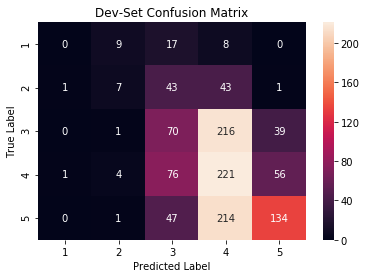

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

labels = [1, 2, 3, 4, 5]
conf_mat = confusion_matrix(list(dev["gold"]), list(dev["depPredics"]))
df_conf = pd.DataFrame(conf_mat, index=labels, columns=labels)
sns.heatmap(df_conf,annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Dev-Set Confusion Matrix')

Text(0.5, 1, 'Train-Set Confusion Matrix')

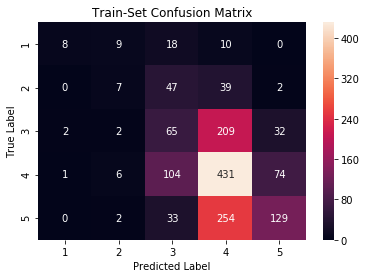

In [10]:
conf_mat = confusion_matrix(list(train["gold"]), list(train["depPredics"]))
df_conf = pd.DataFrame(conf_mat, index=labels, columns=labels)
sns.heatmap(df_conf,annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Train-Set Confusion Matrix')

Text(0.5, 1, 'Dev-Train-Set Confusion Matrix')

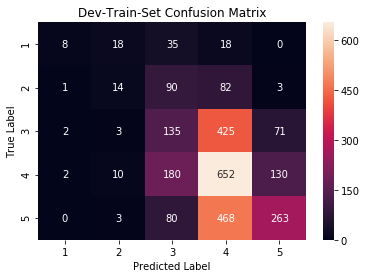

In [11]:
conf_mat = confusion_matrix(list(dev_train["gold"]), list(dev_train["depPredics"]))
df_conf = pd.DataFrame(conf_mat, index=labels, columns=labels)
sns.heatmap(df_conf,annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Dev-Train-Set Confusion Matrix')